In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = sm.datasets.engel.load_pandas().data

In [3]:
data.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


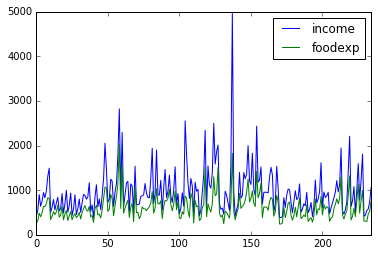

In [4]:
data.plot()

In [5]:
mod = smf.quantreg('foodexp ~ income', data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Thu, 25 Apr 2019   No. Observations:                  235
Time:                        10:28:14   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [6]:
quantiles = np.arange(.05, .96, .1)

def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['income']] + \
            res.conf_int().loc['income'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])

ols = smf.ols('foodexp ~ income', data).fit()
ols_ci = ols.conf_int().loc['income'].tolist()
print(ols_ci)
ols = dict(a = ols.params['Intercept'],
           b = ols.params['income'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[0.4568738130184233, 0.5134830343354237]
      q           a         b        lb        ub
0  0.05  124.880101  0.343361  0.268632  0.418090
1  0.15  111.693660  0.423708  0.382780  0.464636
2  0.25   95.483539  0.474103  0.439900  0.508306
3  0.35  105.841294  0.488901  0.457759  0.520043
4  0.45   81.083647  0.552428  0.525021  0.579835
5  0.55   89.661370  0.565601  0.540955  0.590247
6  0.65   74.033436  0.604576  0.582169  0.626982
7  0.75   62.396584  0.644014  0.622411  0.665617
8  0.85   52.272216  0.677603  0.657383  0.697823
9  0.95   64.103964  0.709069  0.687831  0.730306
{'lb': 0.4568738130184233, 'a': 147.47538852370573, 'ub': 0.5134830343354237, 'b': 0.48517842367692354}


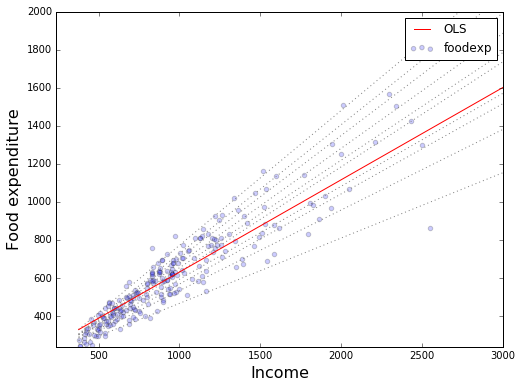

In [7]:
x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data.income, data.foodexp, alpha=.2)
ax.set_xlim((240, 3000))
ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('Income', fontsize=16)
ax.set_ylabel('Food expenditure', fontsize=16);



Populating the interactive namespace from numpy and matplotlib


/home/ostapkharysh/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['legend', 'mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


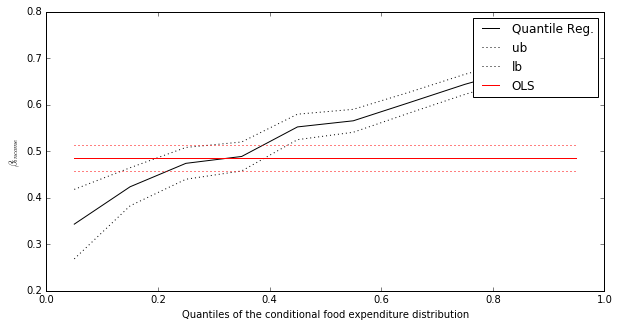

In [8]:
# necessary for the plot to appear in a Jupyter
%matplotlib inline
# Control the default size of figures in this Jupyter 
%pylab inline
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)


n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{income}$')
plt.xlabel('Quantiles of the conditional food expenditure distribution')
plt.legend()
plt.show()

In [9]:
## Plot the changes in the quantile coefficients plt.figure(6) params.plot(x = 'qt', y = ['x_coef','cf_lower_bound', 'cf_upper_bound'],          title = 'Slope for different quantiles', kind ='line', style = ['b-','r--','g--'])

## LINEAR REGRESSION VS QUANTILE REGRESSION

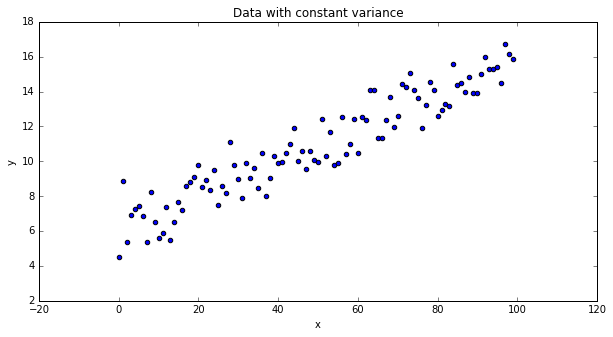

In [10]:
import numpy as np 
import matplotlib.pyplot as plt 

## Generate some data with constant variance /noise
x = np.arange(100).reshape(100,1)
intercept_ = 6
slope_ = 0.1
## non constant error
error_ = np.random.normal(size = (100,1), loc = 0.0, scale = 1)
## Regression equation
y = intercept_ + slope_ * x + error_

plt.figure(1)
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Data with constant variance")

Mean squared error: 1.00
Variance score: 0.89


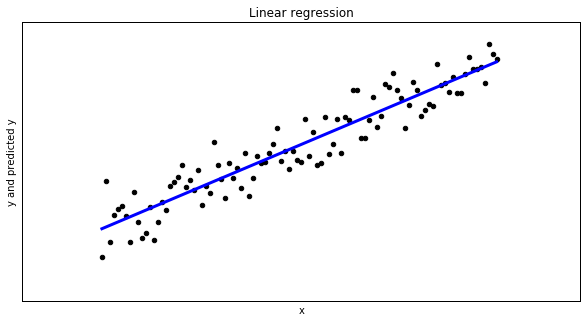

In [11]:
## Let us do a least square regression on the above dataset
from sklearn.linear_model import LinearRegression

model1 = LinearRegression(fit_intercept = True, normalize = False)
model1.fit(x, y)

y_pred1 = model1.predict(x)

print("Mean squared error: {0:.2f}"
      .format(np.mean((y_pred1 - y) ** 2)))
print('Variance score: {0:.2f}'.format(model1.score(x, y)))

## Plot the regression
plt.figure(2)
plt.scatter(x, y,  color='black')
plt.plot(x, y_pred1, color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())
plt.xlabel("x")
plt.ylabel("y and predicted y")
plt.title("Linear regression")

#### WHY WE NEED A QUANTILE REGRESSION

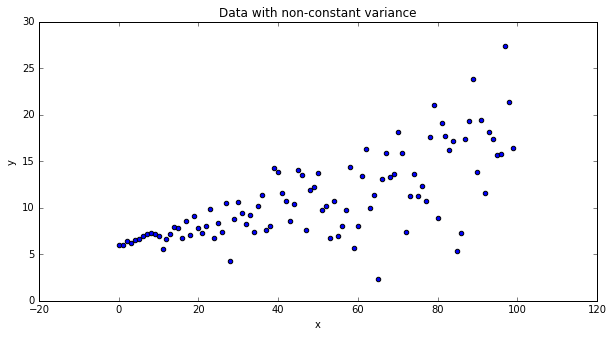

In [12]:
## Generate some data with non-constant variance
x_ = np.arange(100).reshape(100,1)
intercept_ = 6
slope_ = 0.1
## Non constant variance
var_ = 0.1 + 0.05 * x_
## non constant error
error_ = np.random.normal(size = (100,1), loc = 0.0, scale = var_)
## Regression equation
y_ = intercept_ + slope_ * x + error_

plt.figure(3)
plt.scatter(x_, y_)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Data with non-constant variance")

Mean squared error: 10.62
Variance score: 0.50


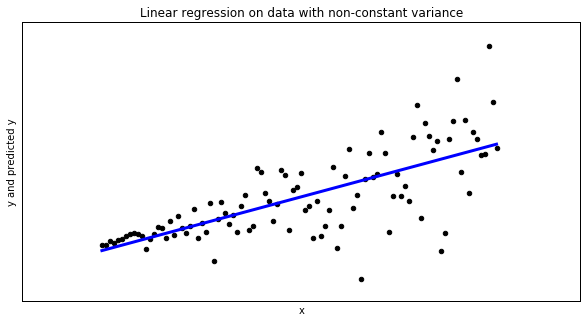

In [13]:
## Try to fit a linear regression
model2 = LinearRegression(fit_intercept = True, normalize = False)
model2.fit(x_, y_)

y_pred2 = model2.predict(x_)

print
print("Mean squared error: {0:.2f}"
      .format(np.mean((y_pred2 - y_) ** 2)))
print('Variance score: {0:.2f}'.format(model1.score(x_, y_)))

## Plot the regression
plt.figure(4)
plt.scatter(x_, y_,  color='black')
plt.plot(x_, y_pred2, color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())
plt.xlabel("x")
plt.ylabel("y and predicted y")
plt.title("Linear regression on data with non-constant variance")

In [14]:
## Quantile regression for the median, 0.5th quantile
import pandas as pd 
data = pd.DataFrame(data = np.hstack([x_, y_]), columns = ["x", "y"])
print(data.head())

import statsmodels.formula.api as smf


mod = smf.quantreg('y ~ x', data)
res = mod.fit(q=.5)
print(res.summary())

     x         y
0  0.0  5.982098
1  1.0  6.024954
2  2.0  6.388928
3  3.0  6.263633
4  4.0  6.559918
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.3873
Model:                       QuantReg   Bandwidth:                       2.622
Method:                 Least Squares   Sparsity:                        6.645
Date:                Thu, 25 Apr 2019   No. Observations:                  100
Time:                        10:28:16   Df Residuals:                       98
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9376      0.660      9.003      0.000       4.629       7.246
x              0.1087      0.012      9.443      0.000       0.086       0.132


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [15]:
## Build the model for other quantiles
quantiles = np.arange(0.1,1,0.01)
print(quantiles)
models = []
params = []

for qt in quantiles:
    print(qt)
    res = mod.fit(q = qt)
    models.append(res)
    params.append([qt, res.params['Intercept'], res.params['x']] + res.conf_int().ix['x'].tolist())


params = pd.DataFrame(data = params, columns = ['qt','intercept','x_coef','cf_lower_bound','cf_upper_bound'])

print(params)

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99]
0.1
0.11


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ostapkharysh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


0.12
0.13
0.13999999999999999
0.14999999999999997
0.15999999999999998
0.16999999999999998
0.17999999999999997
0.18999999999999995
0.19999999999999996
0.20999999999999996
0.21999999999999995
0.22999999999999995
0.23999999999999994
0.24999999999999992
0.2599999999999999
0.2699999999999999
0.2799999999999999
0.2899999999999999
0.29999999999999993
0.30999999999999994
0.3199999999999999
0.32999999999999985
0.33999999999999986
0.34999999999999987
0.3599999999999999
0.3699999999999999
0.3799999999999999
0.3899999999999999
0.3999999999999998
0.4099999999999998
0.4199999999999998
0.4299999999999998
0.43999999999999984
0.44999999999999984
0.45999999999999985
0.46999999999999986
0.47999999999999976
0.48999999999999977
0.4999999999999998
0.5099999999999998
0.5199999999999998
0.5299999999999998
0.5399999999999998
0.5499999999999998


/usr/local/lib/python3.5/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


0.5599999999999997
0.5699999999999997
0.5799999999999997
0.5899999999999997
0.5999999999999998
0.6099999999999998
0.6199999999999998
0.6299999999999997
0.6399999999999997
0.6499999999999997
0.6599999999999997
0.6699999999999997
0.6799999999999997
0.6899999999999997
0.6999999999999996
0.7099999999999996
0.7199999999999996
0.7299999999999996
0.7399999999999997
0.7499999999999997
0.7599999999999997
0.7699999999999997
0.7799999999999997
0.7899999999999996
0.7999999999999996
0.8099999999999996
0.8199999999999996
0.8299999999999996
0.8399999999999996
0.8499999999999996
0.8599999999999995
0.8699999999999996
0.8799999999999996
0.8899999999999996
0.8999999999999996
0.9099999999999996
0.9199999999999996
0.9299999999999996
0.9399999999999996
0.9499999999999995
0.9599999999999995
0.9699999999999995
0.9799999999999995
0.9899999999999995
      qt  intercept    x_coef  cf_lower_bound  cf_upper_bound
0   0.10   6.006249  0.018705       -0.010214        0.047625
1   0.11   5.982102  0.033600        0.0

/usr/local/lib/python3.5/dist-packages/statsmodels/regression/quantile_regression.py:237: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)


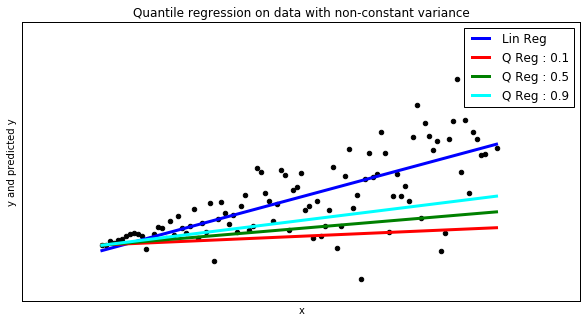

In [16]:
plt.figure(5)
plt.scatter(x_, y_,  color='black')
plt.plot(x_, y_pred2, color='blue',
         linewidth=3, label='Lin Reg')

y_pred3 = models[0].params['Intercept'] + models[0].params['x'] * x_
plt.plot(x_, y_pred3, color='red',
         linewidth=3, label='Q Reg : 0.1')

y_pred4 = models[4].params['Intercept'] + models[4].params['x'] * x_
plt.plot(x_, y_pred4, color='green',
         linewidth=3, label='Q Reg : 0.5')


y_pred5 = models[8].params['Intercept'] + models[8].params['x'] * x_
plt.plot(x_, y_pred5, color='cyan',
         linewidth=3, label='Q Reg : 0.9')


plt.xticks(())
plt.yticks(())
plt.xlabel("x")
plt.ylabel("y and predicted y")
plt.title("Quantile regression on data with non-constant variance")
plt.legend()

In [29]:
params

,qt,intercept,x_coef,cf_lower_bound,cf_upper_bound
0,0.10,6.006249,0.018705,-0.010214,0.047625
1,0.11,5.982102,0.033600,0.010244,0.056956
2,0.12,5.982102,0.035134,0.012046,0.058222
3,0.13,5.989916,0.035037,0.012006,0.058069
4,0.14,5.988856,0.036098,0.010882,0.061313
5,0.15,5.988445,0.036509,0.010567,0.062452
6,0.16,5.982713,0.042242,0.017496,0.066987
7,0.17,5.982098,0.043138,0.018441,0.067835
8,0.18,5.971625,0.053330,0.031896,0.074764
9,0.19,5.795554,0.062989,0.044560,0.081419


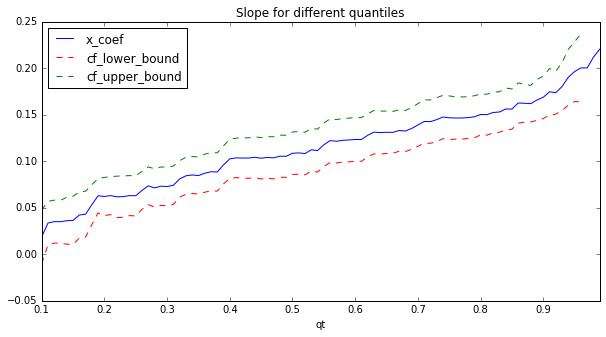

In [17]:
# Plot the changes in the quantile coefficients
plt.figure(6)
params.plot(x = 'qt', y = ['x_coef','cf_lower_bound', 'cf_upper_bound'], 
title = 'Slope for different quantiles', kind ='line', style = ['b-','r--','g--'])

## GARCH ARCH

In [18]:

# necessary for the plot to appear in a Jupyter
%matplotlib inline
# Control the default size of figures in this Jupyter 
%pylab inline
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

Populating the interactive namespace from numpy and matplotlib


/home/ostapkharysh/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [19]:
from random import gauss
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

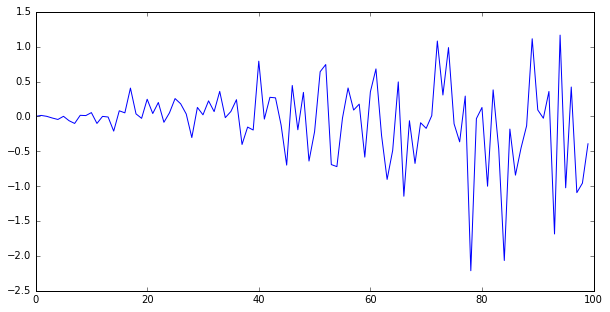

In [20]:
# create a simple white noise with increasing variance
from random import gauss
from random import seed
from matplotlib import pyplot

# seed pseudorandom number generator
seed(1)
# create dataset
data = [gauss(0, i*0.01) for i in range(0,100)]
# plot
pyplot.plot(data)
pyplot.show()

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

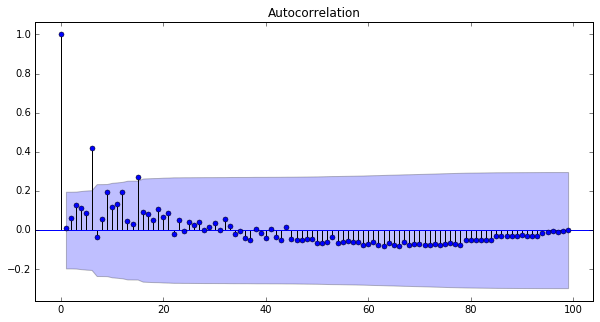

In [22]:
plot_acf([x**2 for x in data])
pyplot.show()

In [23]:
n_test = 10
train, test = data[:-n_test], data[-n_test:]

In [24]:
model = arch_model(train, mean='Zero', vol='ARCH', p=15)

In [25]:
model_fit = model.fit()

Iteration:      1,   Func. Count:     18,   Neg. LLF: 41.42285909902891
Iteration:      2,   Func. Count:     37,   Neg. LLF: 38.58236083168643
Iteration:      3,   Func. Count:     56,   Neg. LLF: 36.70857630115163
Iteration:      4,   Func. Count:     75,   Neg. LLF: 35.64329949592393
Iteration:      5,   Func. Count:     94,   Neg. LLF: 34.388550595379975
Iteration:      6,   Func. Count:    113,   Neg. LLF: 31.603119552517732
Iteration:      7,   Func. Count:    132,   Neg. LLF: 30.180005155417653
Iteration:      8,   Func. Count:    150,   Neg. LLF: 28.719725365835618
Iteration:      9,   Func. Count:    169,   Neg. LLF: 25.76384751972326
Iteration:     10,   Func. Count:    189,   Neg. LLF: 25.732447890170047
Iteration:     11,   Func. Count:    208,   Neg. LLF: 25.649898218420457
Iteration:     12,   Func. Count:    227,   Neg. LLF: 25.560400051601007
Iteration:     13,   Func. Count:    247,   Neg. LLF: 25.546556809654177
Iteration:     14,   Func. Count:    266,   Neg. LLF: 25

In [26]:
yhat = model_fit.forecast(horizon=n_test)
var = [i*0.01 for i in range(0,100)]

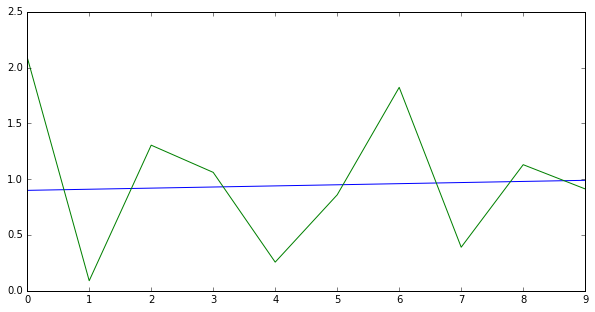

In [27]:
import matplotlib.pyplot as plt
plt.plot(var[-n_test:])
plt.plot(yhat.variance.values[-1, :])
plt.show()

Iteration:      1,   Func. Count:     18,   Neg. LLF: 41.42285909902891
Iteration:      2,   Func. Count:     37,   Neg. LLF: 38.58236083168643
Iteration:      3,   Func. Count:     56,   Neg. LLF: 36.70857630115163
Iteration:      4,   Func. Count:     75,   Neg. LLF: 35.64329949592393
Iteration:      5,   Func. Count:     94,   Neg. LLF: 34.388550595379975
Iteration:      6,   Func. Count:    113,   Neg. LLF: 31.603119552517732
Iteration:      7,   Func. Count:    132,   Neg. LLF: 30.180005155417653
Iteration:      8,   Func. Count:    150,   Neg. LLF: 28.719725365835618
Iteration:      9,   Func. Count:    169,   Neg. LLF: 25.76384751972326
Iteration:     10,   Func. Count:    189,   Neg. LLF: 25.732447890170047
Iteration:     11,   Func. Count:    208,   Neg. LLF: 25.649898218420457
Iteration:     12,   Func. Count:    227,   Neg. LLF: 25.560400051601007
Iteration:     13,   Func. Count:    247,   Neg. LLF: 25.546556809654177
Iteration:     14,   Func. Count:    266,   Neg. LLF: 25

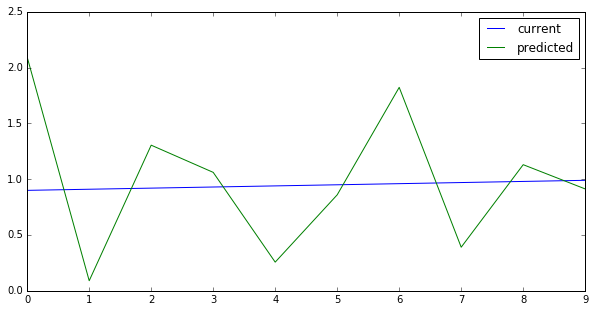

In [28]:
# example of ARCH model
from random import gauss
from random import seed
from matplotlib import pyplot
from arch import arch_model
# seed pseudorandom number generator
seed(1)
# create dataset
data = [gauss(0, i*0.01) for i in range(0,100)]
# split into train/test
n_test = 10
train, test = data[:-n_test], data[-n_test:]
# define model
model = arch_model(train, mean='Zero', vol='ARCH', p=15)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon=n_test)
# plot the actual variance
var = [i*0.01 for i in range(0,100)]
pyplot.plot(var[-n_test:], label ='current')
# plot forecast variance
pyplot.plot(yhat.variance.values[-1, :], label='predicted')
plt.legend(loc='best')
plt.show()